In [1]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
!nvidia-smi

Fri Apr  8 12:02:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   25C    P8     1W / 250W |   4428MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [4]:
# !kill -9 893242

In [5]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 0
# print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [7]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [8]:
!ls
data_zip_file = './local1_folder.zip'
# data_zip_file2 = './local1_folder_temp.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

CNN.ipynb
Inception-Copy1.ipynb
Inception.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal.ipynb
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt16_fc_1e-3_1_nofreeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3_1.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-3_freeze_specificlayer.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-4_freeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_only2048_1e-4_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_f1_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_u

# Data preprocessing

## Image data

In [9]:
data_zip = zipfile.ZipFile(data_zip_file)

In [10]:
# data_zip2 = zipfile.ZipFile(data_zip_file2)

In [11]:
len(data_zip.namelist())

58766

In [12]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

True

local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x734 at 0x7F6852AB00D0>
(734, 800, 3)


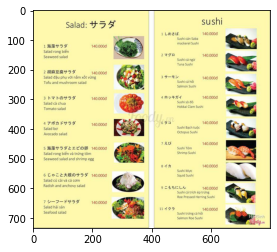

In [13]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [14]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [15]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)


data_df1[['Comment', 'Rating']].head()

,Comment,Rating
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",1.0


In [16]:
data_df4.shape

(3093, 11)

In [17]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [18]:
data_df.shape

(14174, 11)

In [19]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [20]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 0
image_urls              0
Food_score_cmt          0
Services_score_cmt      0
Atmosphere_score_cmt    0
Position_score_cmt      0
Price_score_cmt         0
Rating                  0
dtype: int64

In [21]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.0,9.0,5.0,5.0,5.0,5.8
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,8.0,9.0
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,10.0,9.4
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,1.0,5.0,5.0,6.0,6.0,4.6
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [23]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 8) & (data_df['score'] <= 8)][['Comment','score']].sort_values(by=['score'])

,Comment,score
8,Giữa cái thời tiết HN sớm trưa mưa nắng thất t...,8.0
9677,Sáng nào mình cx phải ăn phở ở đây ms chịu đc ...,8.0
9701,"Hàng xôi tấp nập người ghé ăn & mua mang đi, n...",8.0
9705,"Quán chè nhỏ nhỏ, đối diện bakery Tati. Cô chủ...",8.0
9713,❤ Vị trí : hàng này mới mở dạo gần đây. Nằm ng...,8.0
...,...,...
4892,* mùa dịch ăn gì ??🤔🤔\nĐang mùa dịch thế này c...,8.0
4907,Suất đặc biệt cơm gà + sườn ship Now,8.0
4955,Chè sầu chính hãng nè cả nhà 😻 viêm họng mà vẫ...,8.0
5034,"Nhân ngày xe bus hỏng đúng quán ding tea, mình...",8.0


In [24]:
data_df['Comment'][8]

'Giữa cái thời tiết HN sớm trưa mưa nắng thất thường, tối phần phật gió như này thì việc ngồi nhâm nhâm nhi nhi em caramen hoa quả này là 1 điều thật tuyệt - thơm thơm ngậy ngậy của caramen, vị thanh mát của các loại hoa quả: dưa hấu, xoài, thanh long, mít....được kết hợp lại với nhau rất thú vị, cốc còn rất là đầy đặn nữa chứ. Cơ mà anh chị chủ quán làm ngon quá đi, cứ bị nghiện ý, mỗi ngày sẽ nếm 1 vị: sữa chua thạch lá nếp nè, sc hoa quả, chè khoai dẻo nè.....chu choa v.v.....vân vân và mây mây...'

In [25]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

1    6953
2    4194
0    3023
Name: label, dtype: int64


<AxesSubplot:>

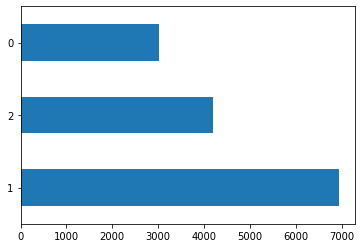

In [26]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [27]:
data_df[['Comment','label', 'score']].head()

,Comment,label,score
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,0,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",1,9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",1,9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,0,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",0,1.0


In [28]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,0


In [29]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [30]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [31]:
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    1
score         0
label         0
dtype: int64

In [32]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

In [33]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0


1    6952
2    4194
0    3023
Name: label, dtype: int64


<AxesSubplot:>

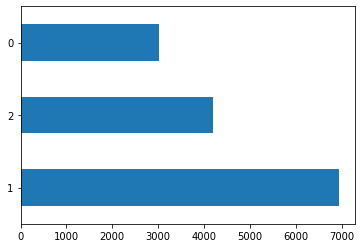

In [34]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [35]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [36]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [37]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [38]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(12, 8)

In [39]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    chưa bao_giờ phải đăng_nhập để bình_luận về đồ...
4188    ko biết các mẹ đặt ntn nhưng hnay em có gọi su...
4189    hôm_nay mình có vc ko đi ra ngoài ăn đc nên mì...
4190    món iberico cắt từ đùi heo tại bàn đặc_sản của...
Name: preprocess_comment, dtype: object

In [40]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

195      1
558      1
714      1
1102     1
1168     1
1452     1
1556     1
1629     1
2200     1
2503     1
2535     1
2642     1
2687     1
3158     1
3163     1
3216     1
3314     1
3510     1
3964     1
3989     1
4021     1
4179     1
4420     1
4903     1
5103     1
6020     1
6128     1
6423     1
6727     1
7239     1
7641     1
7791     1
8273     1
8872     1
9089     1
9432     1
10199    1
10499    1
10559    1
10825    1
11079    1
12357    1
12619    1
13333    1
13540    1
13930    1
Name: preprocess_comment, dtype: int64

In [41]:
a

0         56
1         43
2         38
3         34
4         74
        ... 
14164    107
14165    185
14166     17
14167    319
14168    133
Name: preprocess_comment, Length: 14169, dtype: int64

In [42]:
data_df['Comment'][195]

'Ổn'

<AxesSubplot:>

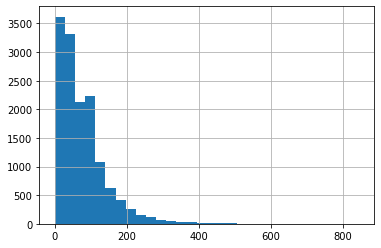

In [43]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

# Load BPE, Vocab of PhoBERT and DataGen

In [44]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    imgs.extend(bt[0])
    img_len.append(len(bt[0]))
    labels.append(bt[1])

  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  imgs_torch, img_len, labels

In [46]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    
    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
      img = Image.open(data_zip.open(path))
      if self.transform is not None:
        img = self.transform(img)
      img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return ( img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 16, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [47]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0].shape)
    print(sum(bat[1]))
    print(len(bat[2]))

1    6952
2    4194
0    3023
Name: label, dtype: int64
1    5562
2    3355
0    2418
Name: label, dtype: int64
1    695
2    419
0    303
Name: label, dtype: int64
1    695
2    420
0    302
Name: label, dtype: int64
0
torch.Size([27, 3, 299, 299])
27
16


In [48]:
bat[0].shape

torch.Size([24, 3, 299, 299])

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda



# PhoBERT

In [50]:
# from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
# from transformers import RobertaForSequenceClassification

# pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
# pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [51]:
# class Bert_Lstm(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.PhoBERT = AutoModel.from_pretrained("vinai/phobert-base")

#     self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
#   def forward(self, texts):
#     bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
#     bert_out = bert_out['last_hidden_state']
#     out, _ = self.lstm(bert_out)
#     feature_extract = out[:,-1,:].contiguous()

#     return feature_extract

In [52]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [53]:
from torchvision.models import inception_v3

In [54]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat
#     self.flat = nn.Linear(2048, 128)
#     self.cl = nn.Linear(2048,3)
    self.ffn = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(128, 3),
        )

  def process(self, feature, len_img_list):
    max_fea = torch.zeros(len(len_img_list), 2048, feature.shape[-1], feature.shape[-1]).to(device)
    start = 0
    for idx, num in enumerate(len_img_list):
      max_fea[idx] = feature[start:start+num].max(0)[0]
      start += num

    return max_fea
  

  def forward(self, image, len_img_list):
    feature = self.incept_sequen(image)
#     print(feature.shape)
    feature = self.process(feature, len_img_list)
#     print(feature.shape)
    feature = self.avgpool(feature)
#     print(feature.shape)
    feature = self.drop(feature)
#     print(feature.shape)

    img_fea = feature.reshape(-1, 2048)
#     img_fea = feature.contiguous().view(-1, 2048)
    # out = self.avgpool(feature)
    # out = out.contiguous().view(-1, 2048)
#     out = self.process(img_fea, len_img_list)
    logits = self.ffn(img_fea)
#     logits = self.cl(img_fea)
    
    return logits

In [88]:
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
  def __init__(self):
    super(CNN_LSTM, self).__init__()

    # CNN for the posters
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5*2*128, 512)

    # Concat layer for the combined feature space
#     self.combined_fc1 = nn.Linear(640, 256)
#     self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(512, 3)


  def forward(self, cnn_inp):

    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5*2*128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))
    
    out = self.output_fc(cnn_out)

    return out

In [82]:
# test_mod = Inception()
# test_mod.to(device)
# i1 = bat[0].to(device)
# # i2 = bat[1].to(device)
# ot = test_mod(i1, bat[1])

In [83]:
# ot.shape

In [84]:
# mod = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc = nn.Sequential(*list(mod.children())[:-1])
# inc

In [85]:
# a = torch.rand(16, 3,299,299)
# ot = inc(a)
# ot.shape

In [86]:
# test = Inception()
# ot = test(a)

In [87]:
# !pip install tensorflow

In [88]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [89]:
# !pip install tensorflow

In [90]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [91]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [56]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [57]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [58]:
# class Concatmodal(nn.Module):
#   def __init__(self):
#     super(Concatmodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
  
#   def forward(self, image, inputs, len_img_list, labels=None):
#     for key in inputs:
#         inputs[key] = inputs[key].to(device)
#     image = image.to(device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image, len_img_list)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out


In [75]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100

  counter = 0
  # total = 0

  model.train()

  soft_m = nn.Softmax(dim=-1)
  train_preds = np.array([])
  train_labels = np.array([])

  for i, (images, len_img_list, labels) in enumerate(tqdm(dm.train_dataloader())):
      counter += 1
      labels = labels.to(device)
      images = images.to(device)
    
      optimizer.zero_grad()
    
      outputs = model(images)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']

  return train_loss, train_ac

In [76]:
# b = torch.rand(1,3, requires_grad=True)
# print(b.requires_grad)

In [77]:
# m = torch.argmax(b, dim=-1)
# print(m.requires_grad)

In [78]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
#   val_preds = torch.tensor([], device=device)
#   val_labels = torch.tensor([], device = device)
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)
        images = images.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)
        
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
#         output_scores = output_scores.cpu().numpy()

        val_running_loss += loss.item()
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    
#   val_preds = val_preds.cpu().numpy()
#   val_labels = val_labels.cpu().numpy()

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
#   val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']


  return val_loss, val_ac


In [79]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, ( images, inputs, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)
        images = images.to(device)

        outputs = model(images)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
  print('Confusion', confusion_matrix(test_labels, test_preds))

  # test_loss = test_running_loss / counter



In [64]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [65]:
# testing(mo, dm)

In [66]:
def save_checkpoint(state, filename='my_checkpoint_Cnn_seed0_bt16.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [67]:
%ls

CNN.ipynb
Inception-Copy1.ipynb
Inception.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal.ipynb
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt16_fc_1e-3_1_nofreeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3_1.pth.tar
my_checkpoint_incept_seed0_bt16_fc_1e-3.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-3_freeze_specificlayer.pth.tar
my_checkpoint_incept_seed0_bt16_fc_2048_re512_re128_1e-4_freeze.pth.tar
my_checkpoint_incept_seed0_bt16_fc_only2048_1e-4_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_f1_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze.pth.tar
my_checkpoint_multi_modal_mrTrong_freeze_weight.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_unfreeze_f1_continue_10epoch.pth.tar
my_checkpoint_multi_modal_mrTrong_u

In [68]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [69]:
def freeze(model):  
  # for param in model.BERT.PhoBERT.parameters():
  #   param.requires_grad = False
  for param in model.incept.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [89]:
model = CNN_LSTM()
model

CNN_LSTM(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=1280, out_features=512, bias=True)
  (output_fc): Linear(in_features=512, out_features=3, bias=True)
)

In [99]:
model = freeze(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

24,949,707 total parameters.
1,115,139 training parameters.


In [103]:
for name, child in model.incept_sequen.named_children():
#     print(name)
    if name in ['17']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

17 has been unfrozen.


In [107]:
for name, child in model.incept_sequen.named_children():
    print(name)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [108]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

24,949,707 total parameters.
7,191,939 training parameters.


In [96]:
# model = Inception()
# model = freeze(model)
# model.to(device)

In [71]:
# model = freeze(model)
# model.to(device)

In [72]:
# model

In [73]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [90]:
from torch.optim import lr_scheduler
import time

train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]

#define model
# model = Concatmodal()
# model = freeze(model)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
# optimizer = torch.optim.Adam([
#         {'params': model.BERT.lstm.parameters()},  
#         {'params': model.incept.flat.parameters()},  
#         {'params': model.dense.parameters()},       
#         {'params': model.cl.parameters()},       
#         {'params': model.BERT.PhoBERT.parameters(), 'lr': 2e-5},
#         {'params': model.incept.incept.parameters(), 'lr': 2e-5}
#     ], lr=3e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
since = time.time()

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print('Train acc', train_ac)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')
    
  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'val_epoch_loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
testing(model, dm)

898,243 total parameters.
898,243 training parameters.
Epoch 0 of 20


  0%|                                                   | 0/709 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 1280]' is invalid for input of size 1245184

In [ ]:
# training(model, optimizer)
print(next(model.parameters()).device)

In [101]:
def show_graph(train_accu, eval_accu, epoch_list, type='F1'):
    plt.plot(epoch_list,train_accu ,'-o')
    plt.plot(epoch_list,eval_accu,'-o')
    plt.xlabel('epoch')
    plt.ylabel(type)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid '+type)

    plt.show()

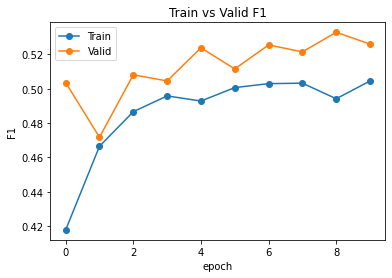

In [102]:
# freeze inception
show_graph(train_f1_list, val_f1_list, epoch_list)

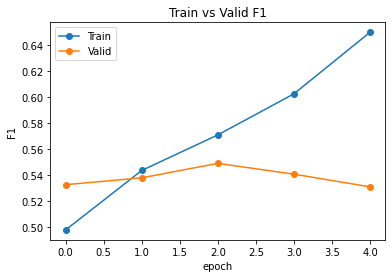

In [110]:
## không freeze 1 layer cuối và train sau khi đã freeze 
show_graph(train_f1_list, val_f1_list, epoch_list)

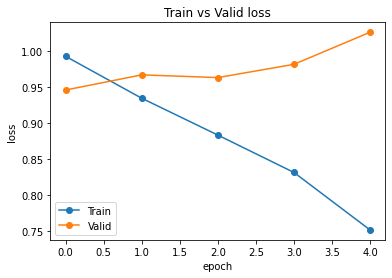

In [111]:
## không freeze 1 layer cuối và train sau khi đã freeze 
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

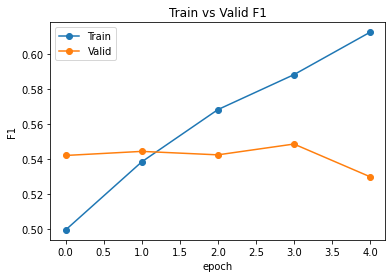

In [96]:
## không freeze 2 layer cuối inception
show_graph(train_f1_list, val_f1_list, epoch_list)

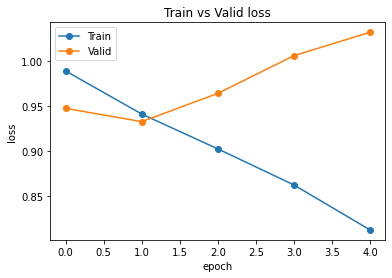

In [97]:
## không freeze 2 layer cuối inception
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

In [66]:
epochs = 10
# model = unfreeze(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'val_epoch_loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)

testing(model, dm)

159,621,451 total parameters.
788,611 training parameters.
Epoch 0 of 10
Epoch 0 Step 59 ave_loss 0.5513
Epoch 0 Step 119 ave_loss 0.5471
Epoch 0 Step 179 ave_loss 0.5584
Epoch 0 Step 239 ave_loss 0.5184
Epoch 0 Step 299 ave_loss 0.5201
Epoch 0 Step 359 ave_loss 0.5685
Epoch 0 Step 419 ave_loss 0.5234
Epoch 0 Step 479 ave_loss 0.5464
Epoch 0 Step 539 ave_loss 0.5545
Epoch 0 Step 599 ave_loss 0.5549
Epoch 0 Step 659 ave_loss 0.5650
Epoch 0 Step 719 ave_loss 0.5372
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82       242
         1.0       0.77      0.87      0.82       551
         2.0       0.63      0.51      0.56       308

    accuracy                           0.75      1101
   macro avg       0.75      0.73      0.73      1101
weighted avg       0.75      0.75      0.75      1101

INFO: Early stopping counter 2 of 5
Train Loss: 0.5450
Val Loss: 0.5903
Val Acc: 0.7530
Epoch 1 of 10
Epoch 1 Step 59 ave_loss 0.5416
Epoch 1 Step 119 

In [96]:
import gc
del model 
gc.collect()

692

In [97]:
torch.cuda.empty_cache()

In [83]:
PATH = "my_checkpoint_incept_seed0_bt16_fc_only2048_1e-4_freeze.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
# model = Concatmodal()
# model.load_state_dict(checkpoint['state_dict'])
model = Inception()
model.to(device)
print(checkpoint['epoch'])

8


In [84]:
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.20      0.74      0.32       302
         1.0       0.00      0.00      0.00       695
         2.0       0.25      0.19      0.22       420

    accuracy                           0.21      1417
   macro avg       0.15      0.31      0.18      1417
weighted avg       0.12      0.21      0.13      1417

test_ac 0.21383203952011293
Macro_f1 0.1781314511084969


/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


In [68]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:     
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)         b 
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


